In [4]:
import numpy as np
from matplotlib import pyplot as plt
import math

In [37]:
class particle_system:
    def __init__(self,grid,creation):#grid:integer tuple
        self.grid=grid
        self.particles=[]
        self.dim=len(self.grid)
        self.__class__.creation=creation
        
    def insert_particles(self,n,update_pos,update_intensity,start_pos=None,intensity=None):
        if start_pos is None:
            pos_data=[np.random.uniform(low=0, high=self.grid[i], size=n) for i in range(self.dim)]
            start_pos=[[pos_data[j][i] for j in range(self.dim)]for i in range(n)]
        if intensity is None:
            intensity=[1 for i in range(n)]
            
        for i in range(n):
            self.particles.append(particle(self.grid,start_pos[i],update_pos,intensity[i],update_intensity))
    def evolve(self,dt):
        print("before: ")
        print(self.intensities())
        for p in self.particles:
            p.evolve(dt)
            if p.intensity==0:#remove if intensity drops to 0
                self.particles.remove(p)
        print("after: ")
        print(self.intensities())
        self.creation(dt)
    def positions(self):
        return [p.pos for p in self.particles]
    def intensities(self):
        return [p.intensity for p in self.particles]

In [38]:
class particle:
    def __init__(self,grid,start_pos,update_pos,intensity,update_intensity):
        self.grid=grid#dimensions of the space it's restricted to
        self.dim=len(self.grid)
        
        self.pos=start_pos#current position
        self.__class__.update_pos=update_pos
        
        self.intensity=intensity#current intensity
        self.__class__.update_intensity = update_intensity
        
    def evolve(self,dt):
        self.pos=self.update_pos(dt)
        self.intensity=self.update_intensity(dt)
        
        

In [7]:
def inside_grid(pos,grid):#assume grid has leftmost bottom corner in 0, check if a given point is inisde of it
    inside_dimensions=[pos[i]>=0 and pos[i]<=grid_dim for i,grid_dim in enumerate(grid)]
    return all(inside_dimensions)

In [8]:
def brownian_update(part,dt,D,drift=None):
    if drift is None:
        drift=[0]*part.dim
    mean=[dt*d for d in drift]
    cov=np.identity(part.dim)*dt*D*2#the 2 term appears because I think that's the 'true' variance formula in Brownian motion but D may as well just be any number, not the diffusion coeff
    dr = np.random.multivariate_normal(mean, cov, 1).T
    if (any([np.abs(dr[i][0])>grid_dim/2 for i,grid_dim in enumerate(part.grid)])):#this is just bad code but we're unlikely to need more dimensions anytime soon
        print("The time step in brownian motion seems to be too large relative to grid size")#just to see if I'm doing anything stupid
    pos=part.pos
    new_pos=list(map(sum, zip(pos, [dr[i][0] for i,d in enumerate(dr)])))
    if inside_grid(new_pos,part.grid):
        return new_pos
    else:#need to figure out where and when it intersects the boundary. For now let's just resample
        return brownian_update(part,dt,D,drift)
        
        
    

It's time to use this simulation to do tracking

In [6]:
sys=particle_system([100,100])
n=5
sys.insert_particles(n,lambda x,y : brownian_update(x,y,1),lambda x,y : 1)

dt=50
beg_pos=sys.positions()
beg_int=sys.intensities()

sys.evolve(dt)

end_pos=sys.positions()
end_int=sys.intensities()


We need to transform it into a transportation problem

In [7]:
a=np.array(beg_int).reshape((n,1))
b=np.array(end_int).reshape((n,1))#try to make the shapes match with all of the linear algebra behind this


In [8]:
def L2_cost(source,sink):
    C=np.empty((len(source),len(sink)))
    for i,pos1 in enumerate(source):
        for j, pos2 in enumerate(sink):
            C[i,j]=np.sqrt(np.sum([(pos1[i]-pos2[i])**2 for i,p in enumerate(pos1)]))
    return C

In [9]:
C = L2_cost(beg_pos,end_pos)

In [10]:
import cvxpy as cp

In [11]:
P=cp.Variable((n,n))

In [12]:
u = np.ones((n,1))
v = np.ones((n,1))
U = [0 <= P, cp.matmul(P,u)==a, cp.matmul(P.T,v)==b]

In [13]:
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
prob = cp.Problem(objective, U)
result = prob.solve()

In [14]:
P.value

array([[1.00000000e+00, 9.16920907e-12, 1.26915755e-11, 4.75507122e-11,
        1.15957600e-11],
       [8.95797521e-12, 1.00000000e+00, 7.59970416e-12, 1.03546522e-11,
        9.38162629e-12],
       [8.70728548e-12, 6.31657692e-12, 1.00000000e+00, 1.44076057e-11,
        7.68379901e-11],
       [4.67822894e-11, 1.03982052e-11, 2.45036634e-11, 1.00000000e+00,
        1.87881625e-11],
       [1.65612922e-11, 1.04147266e-11, 6.16977917e-11, 2.81626093e-11,
        1.00000000e+00]])

Visualise this

In [15]:
beg_x,beg_y= zip(*beg_pos)
end_x,end_y= zip(*end_pos)

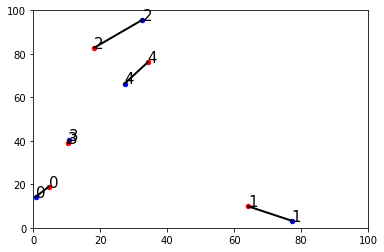

In [16]:
fig,ax=plt.subplots()

ax.set_xlim([0,sys.grid[0]])
ax.set_ylim([0,sys.grid[1]])
ax.scatter(beg_x,beg_y,color='blue',s=20)
ax.scatter(end_x,end_y,color='red',s=20)
for i,pos in enumerate(beg_pos):
    ax.annotate(i,(pos[0],pos[1]),size=15)
for i,pos in enumerate(end_pos):
    ax.annotate(i,(pos[0],pos[1]),size=15)
    
    
for i in range(n):
    for j in range(n):
        if P.value[i,j]>0.1:#so there is a non-neglegible transport between the two
            xvals=[beg_x[i],end_x[j]]
            yvals=[beg_y[i],end_y[j]]
            thickness=1.8*(P.value[i,j]/a[i])+0.2 #scaled by what fraction of the total transport from i it is
            ax.plot(xvals,yvals,linewidth=thickness,color='black')

Let's also try in higher dimension

In [17]:
sys=particle_system([100,100,100])
n=5
sys.insert_particles(n,lambda x,y : brownian_update(x,y,1),lambda x,y : 1)

dt=50
beg_pos=sys.positions()
beg_int=sys.intensities()

sys.evolve(dt)

In [25]:
print(sys.positions())

[[36.24771109591692, 72.69468541054735, 61.93452707049257], [86.57079774794211, 72.62107984752349, 66.49022558501504], [72.17205280208428, 25.271230597250263, 15.375779397794584], [87.17598357834804, 64.31266256489512, 27.45431292171998], [53.85939970191967, 93.72057392795662, 32.2118074594518]]


In [26]:
sys.evolve(dt)

In [27]:
print(sys.positions())

[[47.41726557427453, 63.56343820157555, 64.29850908261396], [82.49524032456263, 70.57530951325593, 48.93407008621144], [71.18136524605373, 22.840849476008465, 20.338557118445205], [92.31053958564986, 47.65289132598014, 17.050413894689186], [46.948764696223634, 84.70086033718484, 15.058576376607505]]


Let's take care of the changes in intensity and creation/disappearance of particles. Let's say that a particle disappears if its intensity drops to 0

In [9]:
def placeholder_intensity_update(part,dt,mean,variance=None,threshold=None):
    if variance is None:
        variance=(dt)**2
    if threshold is None:
        threshold=0.1*mean#if intensity drops below then it disappears
    #print(mean,variance,part.intensity)
    intensity_change=np.random.normal(mean-part.intensity, variance)
    new_int=part.intensity+intensity_change
    #print(part.intensity)
    if new_int<threshold:
        new_int=0
    return new_int

We also need a model for creation. Just do anything for now

In [80]:
def poisson_creation(self,dt,c=1):
    n=np.random.poisson(dt*c)
    self.insert_particles(n,lambda x,y : brownian_update(x,y,1),lambda x,y : placeholder_intensity_update(x,y,1000,10), intensity=[1000]*n)

In [81]:
sys=particle_system([100,100,100],lambda x,y : poisson_creation(x,y,0.01))
n=5
sys.insert_particles(n,lambda x,y : brownian_update(x,y,1),lambda x,y : placeholder_intensity_update(x,y,1000),intensity=[1000]*n)

dt=50
beg_pos=sys.positions()
beg_int=sys.intensities()

sys.evolve(dt)

before: 
[1000, 1000, 1000, 1000, 1000]
after: 
[2547.122341456321, 1000, 1000]


In [92]:
sys.evolve(dt)

before: 
[980.4352645883274, 1003.6466155796928, 992.7807929327205, 993.4353624776597, 992.1345487067819, 992.4468747590238, 996.754555348683, 998.2871170623733, 1005.1777927430617, 997.8971059351097, 1013.3830752246395, 1003.071460156587]
after: 
[1016.9853421784871, 1021.9984932632858, 1022.7694418925641, 991.619977871194, 1009.5342259427441, 1005.5217160364548, 1001.3951775537635, 1006.8702646010662, 999.3043071213568, 996.7218135990167, 1006.3242400337169, 1004.6481857597232]


In [35]:
sys.intensities()

[1, 1, 1, 1000]